In [44]:
import os
from dotenv import load_dotenv
import wrds
import numpy as np
from numpy import log, log1p, exp, sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
PGUSER = os.getenv('PGUSER')
PGPASSWORD = os.getenv('PGPASSWORD')

In [2]:
conn = wrds.Connection()

Loading library list...
Done


In [3]:
# %%time
# conn.get_table(library='crsp', table='dsp500list', rows=10)
# conn.get_table(library='crsp', table='dsf', rows=10)

# getting DAILY returns for SP500 constituents + date range of their belonging to SP500
start_date = '01/01/2003'
df = conn.raw_sql(
        f"select a.*, b.date, b.ret \
        from crsp.dsp500list as a, \
        crsp.dsf as b \
        where a.permno = b.permno \
        and b.date >= a.start and b.date <= a.ending \
        and b.date >= '{start_date}'", date_cols=['start', 'ending', 'date']
    )

# getting additional company attributes / identifiers
temp = conn.raw_sql(
    """select comnam, namedt, nameendt, permno, shrcd, exchcd, ticker
        from crsp.dsenames""", date_cols=['namedt', 'nameendt']
    )

# merging, subsetting
df = df.merge(temp, how='inner', on='permno')
temp = None

# return date is between the range for which company name was used
df = df.loc[(df.date >= df.namedt) & (df.date <= df.nameendt)]

# for exchcd (exchange code) we have 1: NYSE, 2: NYSE MKT, 3: NASDAQ, 4: ARCA
# for shrcd (share code) we have 11: ordinary common shares, need no further definition, US incorporated
df = df.loc[(df.exchcd.isin((1, 2, 3, 4))) & (df.shrcd == 11)]

In [5]:
# permno: permanent code for security (guaranteed to not change versus something like ticker)
# start, ending: start and end dates of SP500 membership
# date, ret: daily return for stock on given date
df.head(5)

,permno,start,ending,date,ret,comnam,namedt,nameendt,shrcd,exchcd,ticker
0,10078,1992-08-20,2010-01-28,2003-01-02,0.086817,SUN MICROSYSTEMS INC,1986-03-04,2004-06-09,11,3,SUNW
5,10078,1992-08-20,2010-01-28,2003-01-03,0.050296,SUN MICROSYSTEMS INC,1986-03-04,2004-06-09,11,3,SUNW
10,10078,1992-08-20,2010-01-28,2003-01-06,0.056338,SUN MICROSYSTEMS INC,1986-03-04,2004-06-09,11,3,SUNW
15,10078,1992-08-20,2010-01-28,2003-01-07,0.013333,SUN MICROSYSTEMS INC,1986-03-04,2004-06-09,11,3,SUNW
20,10078,1992-08-20,2010-01-28,2003-01-08,-0.063158,SUN MICROSYSTEMS INC,1986-03-04,2004-06-09,11,3,SUNW


In [7]:
# caldt  := calendar date
# ewretd := equal-weighted market portfolio return
# vwretd := value-weighted market portfolio return
# sprtrn := SP500 return
sp500 = conn.get_table(library='crsp', table='dsp500', columns=['caldt', 'vwretd', 'ewretd', 'sprtrn'], date_cols=['caldt'])

Sanity Check: manual equal-weighted portfolio construction and correlation

In [15]:
df.dropna(how='any', axis=0, inplace=True); sp500.dropna(how='any', axis=0, inplace=True)

In [58]:
# equal weighted portfolio (manual)
s1 = df.groupby('date').ret.apply(lambda x: x.mean()).to_frame()

# equal weighted portfolio (given)
s2 = sp500.loc[:, ['caldt', 'ewretd']]
s2['ewretd'] = s2.ewretd.astype(float)
s2.set_index('caldt', inplace=True)
s2.index.name = 'date'

temp = pd.merge(s1, s2, how='inner', left_index=True, right_index=True).sort_index()
s1 = s2 = None

In [59]:
temp.corr()

,ret,ewretd
ret,1.00000,0.99929
ewretd,0.99929,1.00000


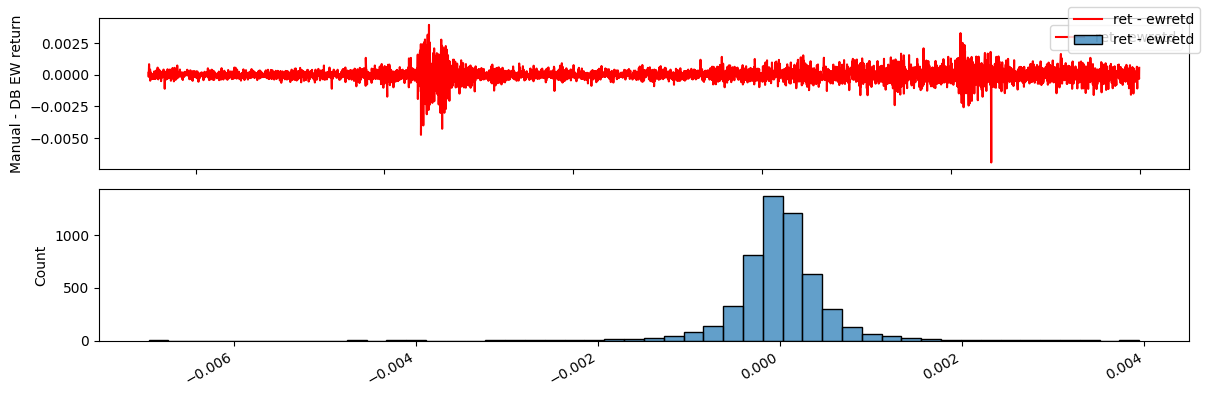

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(12, 4))
sns.lineplot(x=temp.index, y=temp.ret - temp.ewretd, ax=ax[0], label='ret - ewretd', color='red')
sns.histplot(temp.ret - temp.ewretd, ax=ax[1], bins=50, alpha=0.7, label='ret - ewretd')
ax[0].set_ylabel('Manual - DB EW return')
fig.legend(); fig.autofmt_xdate()
plt.tight_layout(); plt.show()

In [ ]:
temp = None
conn.close()